In [1]:
#The below library may need to be installed. if so, uncomment and run the pip install

In [2]:
#pip install pmdarima

In [66]:
#pip install html5lib

In [67]:
#pip install -U googlemaps

In [68]:
#pip install praw

In [69]:
#pip install vaderSentiment

In [ ]:
##### importing all relevant packages
import pandas as pd
import numpy as np

#google places api 
import googlemaps

#webscraping
import requests
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from configparser import ConfigParser

#reddit API
import praw

#sentiment analysis
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

#plotting modules
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 

#Machine Learning
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import mse, rmse 
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#time-series analysis
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
import pmdarima as pm
from pmdarima.arima import ADFTest


#supressing warnings
import warnings
warnings.filterwarnings('ignore')

# Section 1: Comparison of Regression models to predict passenger numbers

In [4]:
#loading in the prepared dataset
dataset = pd.read_csv('merged_df.csv')

In [5]:
dataset.head()

,year,Quarter,passengers,freight,commercial_flights,gdp,gnp,consumer_price_index
0,2005,Q1,4998800.0,18100.0,51100.0,4.790600e+10,4.145900e+10,264.2
1,2005,Q2,6587700.0,18200.0,62000.0,4.953900e+10,4.188200e+10,291.2
2,2005,Q3,7924600.0,27600.0,69500.0,4.844700e+10,4.261900e+10,335.9
3,2005,Q4,5919900.0,36400.0,57300.0,5.111600e+10,4.514100e+10,294.8
4,2006,Q1,5647600.0,36900.0,55400.0,5.097500e+10,4.427400e+10,345.6


## 1.1 Scaling the feature variables

In [6]:
#scaling the relevant columns in the dataset
scaler = StandardScaler()

cols_to_scale = ['freight','commercial_flights','gdp','gnp','consumer_price_index']

df_scale = pd.DataFrame(scaler.fit_transform(dataset[cols_to_scale]),columns=cols_to_scale)
df_scale.head()

,freight,commercial_flights,gdp,gnp,consumer_price_index
0,-3.195606,-0.905928,-0.927972,-0.891519,-1.346856
1,-3.175648,0.264281,-0.806703,-0.845843,-0.745216
2,-1.299598,1.069471,-0.887796,-0.766261,0.250832
3,0.456705,-0.240304,-0.689593,-0.493931,-0.664997
4,0.556495,-0.444286,-0.700064,-0.587551,0.466976


Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

z = (x - u) / s

## 1.2 Multiple Linear Regression

In [7]:
#defining the independent and target feature variables
X = df_scale

#freight is the target feature in this case
y = dataset['passengers']

In [8]:
# Split the data set into Training and Testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,shuffle=False)

# Display the Number of rows and columns before (X, y) and after Splitting (X_train, X_test, y_train, y_test)
X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60, 5), (60,), (45, 5), (15, 5), (45,), (15,))

In [9]:
#instantiating the model
LR_model = LinearRegression()

#fitting the linear regression model
LR_model.fit(X_train, y_train)

y_preds_train = LR_model.predict(X_train)
y_preds_test = LR_model.predict(X_test)  

In [10]:
## accuracy metrics for regression model: 
r_squared_test_LR = r2_score(y_test,y_preds_test)
r_squared_train_LR = r2_score(y_train,y_preds_train)

rmse_test_LR = rmse(y_test, y_preds_test)
mae_test_LR = np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100

print(f'1) the r^2 score for the test set is: {r_squared_test_LR}')
print(f'2) the r^2 score for the training set is: {r_squared_train_LR}')
print(f'3) the root mean squared error for the test set is: {rmse_test_LR}')
print(f'4) the mean absolute error percentage for the test set is: {mae_test_LR}')

1) the r^2 score for the test set is: 0.9104066757028536
2) the r^2 score for the training set is: 0.9103989372315329
3) the root mean squared error for the test set is: 451221.1854871468
4) the mean absolute error percentage for the test set is: 4.2388173109329115


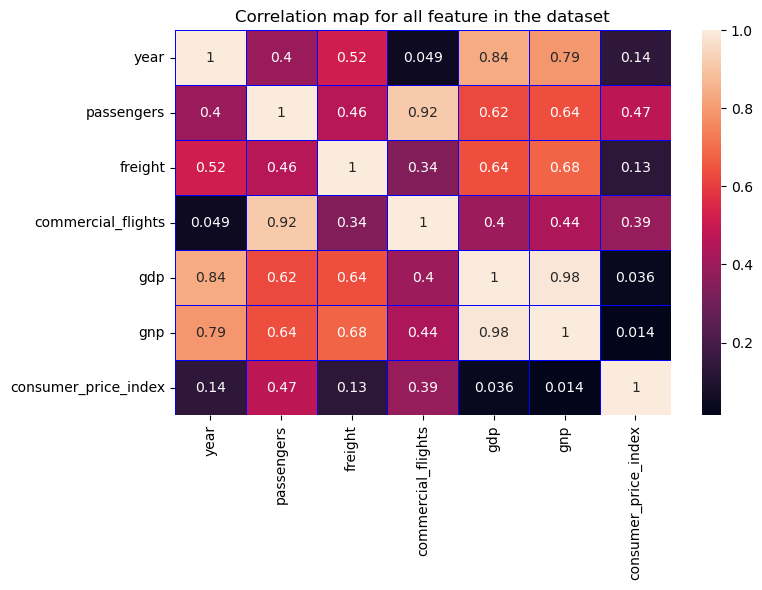

In [11]:
#plotting a heat map to look at the correlation between the features and the target
plt.figure(figsize = (8,5))
dataset_corr= dataset.corr()
sns.heatmap(dataset_corr, annot=True, linecolor="blue",lw=0.5)
plt.title('Correlation map for all feature in the dataset');

## 1.3 Applying PCA due to multi-colinearity between features

First step involved in PCA is determining the number of components I want to leave in the model:

In [12]:
#instantiating PCA, initially leaving all components in (i.e n_components=6)
pca = PCA(n_components=5)

#fitting this to the training and testing data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [13]:
# Store the explauned variance
explained_variance = pca.explained_variance_ratio_

#taking a look at each of the variances
print(explained_variance)

[0.47166863 0.26494728 0.19531682 0.06469065 0.00337662]


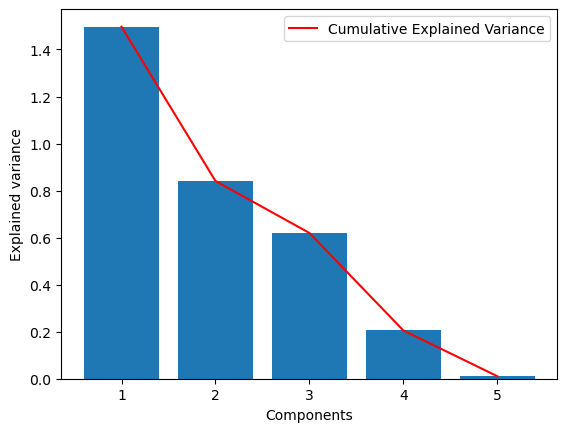

In [14]:
##displaying the PCA components: 
plt.bar(range(1,len(pca.explained_variance_ ) + 1), pca.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1, len(pca.explained_variance_ ) + 1), pca.explained_variance_,c = 'red',label = "Cumulative Explained Variance")
plt.legend(loc = 'best')

From the above plot I have decided to limit the dimensions to 4 principal components. This ensure I am keeping enough of the explained variance, whilst reducing the dimensions of the dataset.

In [15]:
# Apply PCA to the scaled data with number of components set to 4
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [16]:
#fitting the reduced data to the linear regression model
LR_model.fit(X_train_pca, y_train)

LinearRegression()

In [17]:
#making predictions with the updated model
y_preds_train = LR_model.predict(X_train_pca)
y_preds_test = LR_model.predict(X_test_pca) 

In [18]:
## accuracy metrics for regression model: 
r_squared_test_LR_PCA = r2_score(y_test,y_preds_test)
r_squared_train_LR_PCA = r2_score(y_train,y_preds_train)

rmse_test_LR_PCA = rmse(y_test, y_preds_test)
mae_test_LR_PCA = np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100

print(f'1) the r^2 score for the test set is: {r_squared_test_LR_PCA}')
print(f'2) the r^2 score for the training set is: {r_squared_train_LR_PCA}')
print(f'3) the root mean squared error for the test set is: {rmse_test_LR_PCA}')
print(f'4) the mean absolute error percentage for the test set is: {mae_test_LR_PCA}')

1) the r^2 score for the test set is: 0.9109506134401997
2) the r^2 score for the training set is: 0.9044238237372787
3) the root mean squared error for the test set is: 449849.37631501985
4) the mean absolute error percentage for the test set is: 4.103806033935499


## 1.4 Ridge Regression

using GridSearchCV to tune alpha hyperparameter to optimise accuracy

In [19]:
#defining list of params to iterate through
params = {'alpha': [0.01, 0.1, 1, 10]}

ridgeregr = GridSearchCV(Ridge(),param_grid=params, verbose=1)

ridgeregr.fit(X_train_pca, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=Ridge(), param_grid={'alpha': [0.01, 0.1, 1, 10]},
             verbose=1)

In [20]:
ridge = ridgeregr.best_estimator_

# Output the best hyperparameters
print("Best hyperparameters:",ridgeregr.best_params_)

Best hyperparameters: {'alpha': 10}


Applying ridge regression to the train and test data

In [21]:
y_preds_train = ridge.predict(X_train_pca)
y_preds_test = ridge.predict(X_test_pca)

In [22]:
## accuracy metrics for regression model: 
r_squared_test_ridge= r2_score(y_test,y_preds_test)
r_squared_train_ridge = r2_score(y_train,y_preds_train)

rmse_test_ridge = rmse(y_test, y_preds_test)
mae_test_ridge = np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100

print(f'1) the r^2 score for the test set is: {r_squared_test_ridge}')
print(f'2) the r^2 score for the training set is: {r_squared_train_ridge}')
print(f'3) the root mean squared error for the test set is: {rmse_test_ridge}')
print(f'4) the mean absolute error percentage for the test set is: {mae_test_ridge}')

1) the r^2 score for the test set is: 0.5621604683399387
2) the r^2 score for the training set is: 0.8751539285678844
3) the root mean squared error for the test set is: 997491.3584547089
4) the mean absolute error percentage for the test set is: 8.702578897344896


## 1.5 Lasso Regularization:

using GridSearchCV to tune alpha hyperparameter to optimise accuracy

In [23]:
#defining list of params to iterate through
params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

#running gridSearch on params, with the default k-fold cross validation set to 5
lassoregr = GridSearchCV(Lasso(),param_grid=params, verbose=1)

In [24]:
#fitting the lasso model with the optimised value of alpha to the pca reduced training data
lassoregr.fit(X_train_pca, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(estimator=Lasso(), param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10]},
             verbose=1)

In [25]:
lasso = lassoregr.best_estimator_

# Output the best hyperparameters
print("Best hyperparameters:",lassoregr.best_params_)

Best hyperparameters: {'alpha': 10}


In [26]:
# Perform prediction using the best estimator from grid search
y_preds_test = lassoregr.predict(X_test_pca)
y_preds_train = lassoregr.predict(X_train_pca)

In [27]:
## accuracy metrics for regression model: 
r_squared_test_lasso = r2_score(y_test,y_preds_test)
r_squared_train_lasso = r2_score(y_train,y_preds_train)

rmse_test_lasso = rmse(y_test, y_preds_test)
mae_test_lasso = np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100

print(f'1) the r^2 score for the test set is: {r_squared_test_lasso}')
print(f'2) the r^2 score for the training set is: {r_squared_train_lasso}')
print(f'3) the root mean squared error for the test set is: {rmse_test_lasso}')
print(f'4) the mean absolute error percentage for the test set is: {mae_test_lasso}')

1) the r^2 score for the test set is: 0.910926818584004
2) the r^2 score for the training set is: 0.9044238232460701
3) the root mean squared error for the test set is: 449909.47434976394
4) the mean absolute error percentage for the test set is: 4.104309292754859


## 1.6 Random Forrest Regression

In [28]:
#instantiating Random Forest regressor model
RF_model = RandomForestRegressor(n_estimators = 100)
RF_model.fit(X_train_pca, y_train)

RandomForestRegressor()

In [29]:
#making predictions
y_preds_train = RF_model.predict(X_train_pca)
y_preds_test = RF_model.predict(X_test_pca)  

In [30]:
## accuracy metrics for regression model: 
r_squared_test_RF = r2_score(y_test,y_preds_test)
r_squared_train_RF = r2_score(y_train,y_preds_train)

rmse_test_RF = rmse(y_test, y_preds_test)
mae_test_RF = np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100

print(f'1) the r^2 score for the test set is: {r_squared_test_RF}')
print(f'2) the r^2 score for the training set is: {r_squared_train_RF}')
print(f'3) the root mean squared error for the test set is: {rmse_test_RF}')
print(f'4) the mean absolute error percentage for the test set is: {mae_test_RF}')

1) the r^2 score for the test set is: 0.1414316863229481
2) the r^2 score for the training set is: 0.9562795581576824
3) the root mean squared error for the test set is: 1396815.6262085796
4) the mean absolute error percentage for the test set is: 11.85905622769122


## 1.7 Comparing the regression models:

Using the evaluation metrics calculated for each model and creating a dataframe out of them:

In [31]:
#defining arrays to construct comparison dataframe for visualising the results of each model
models = np.array(['multivariate_LR','multivariate_LR_PCA','multivariate_LR_ridge',
                   'multivariate_LR_lasso','Random_Forrest_Regression'])

r_squared_test = np.array([r_squared_test_LR,r_squared_test_LR_PCA,r_squared_test_ridge,r_squared_test_lasso
                           ,r_squared_test_RF])

r_squared_train = np.array([r_squared_train_LR,r_squared_train_LR_PCA,r_squared_train_ridge,r_squared_train_lasso
                           ,r_squared_train_RF])

rmse_test = np.array([rmse_test_LR,rmse_test_LR_PCA,rmse_test_ridge,rmse_test_lasso,rmse_test_RF])

mae_test = np.array([mae_test_LR,mae_test_LR_PCA,mae_test_ridge,mae_test_lasso,mae_test_RF])

In [32]:
#creating a dataframe from arrays
comparison_metrics = pd.DataFrame({'models':models,
                                  'r_squared_test':r_squared_test,
                                  'r_squared_train':r_squared_train,
                                  'rmse_test':rmse_test,
                                  'mae_test':mae_test})

comparison_metrics

,models,r_squared_test,r_squared_train,rmse_test,mae_test
0,multivariate_LR,0.910407,0.910399,4.512212e+05,4.238817
1,multivariate_LR_PCA,0.910951,0.904424,4.498494e+05,4.103806
2,multivariate_LR_ridge,0.562160,0.875154,9.974914e+05,8.702579
3,multivariate_LR_lasso,0.910927,0.904424,4.499095e+05,4.104309
4,Random_Forrest_Regression,0.141432,0.956280,1.396816e+06,11.859056


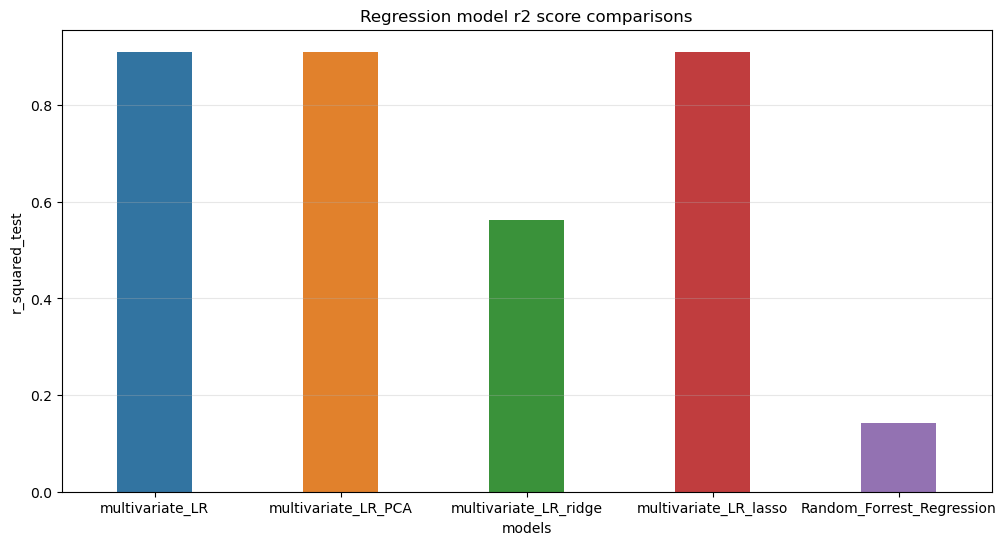

In [35]:
#plotting the accuracies using the r^2 score of each of the models used
plt.figure(figsize=(12,6))
sns.barplot(x='models',y='r_squared_test',data=comparison_metrics,width=.4)
plt.grid(axis='y',alpha=.3)
plt.title('Regression model r2 score comparisons')
plt.show()

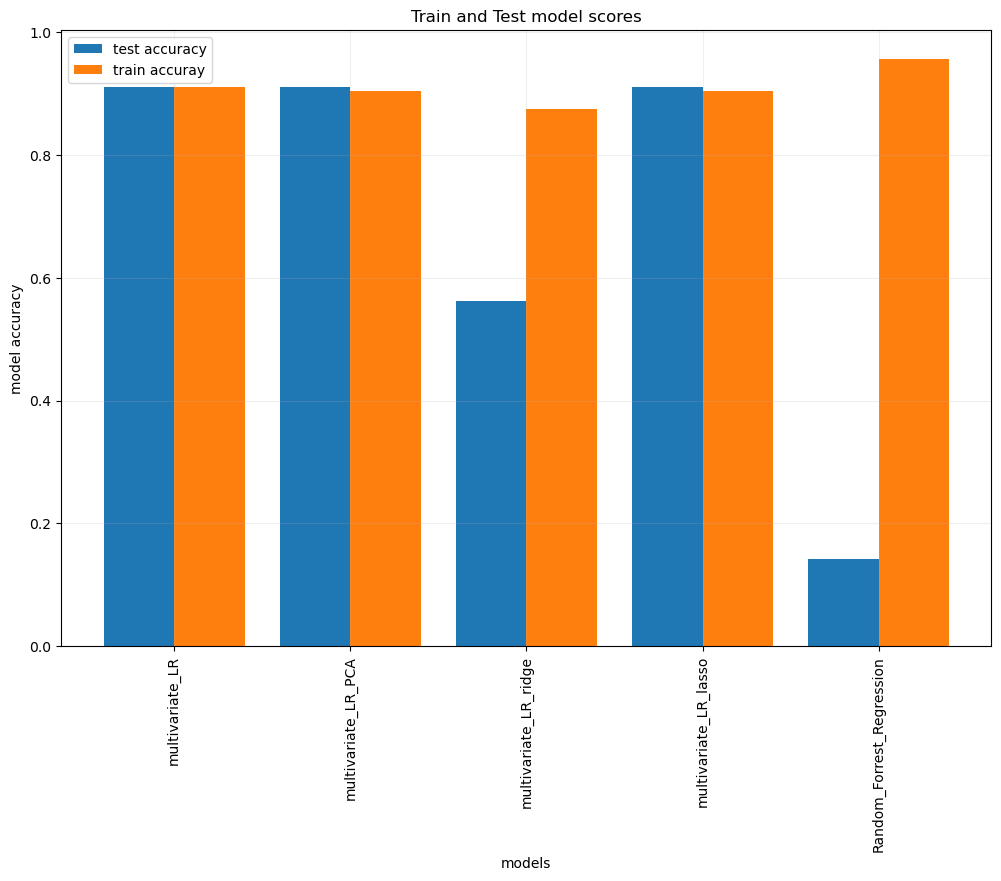

In [36]:
#plotting a grouped bar chart using the train and testing accuracies
plt.figure(figsize=(12,8))
X_axis = np.arange(len(comparison_metrics['models']))   
plt.bar(X_axis - 0.2, comparison_metrics['r_squared_test'], 0.4, label = 'test accuracy') 
plt.bar(X_axis + 0.2, comparison_metrics['r_squared_train'], 0.4, label = 'train accuray') 

plt.xticks(X_axis, comparison_metrics['models'],rotation = 90) 
plt.xlabel("models") 
plt.ylabel("model accuracy") 
plt.title("Train and Test model scores") 
plt.legend() 
plt.grid(True,alpha=0.2)
plt.show() 

#### The above grouped bar chart was chosen to visualise the results of the tests as this allows us to identify any models that are suffering from overfitting (i.e train accuracy is much greater than testing accuracy), underfitting (low training score).

## Section 2: Time series analysis - passenger numbers forecasting using ARIMA 

steps involved in ARIMA: 

- Importing the data
- preprocess the data (This will include creating timestamps, converting the dtype of date/time column, making the series univariate)
- Assessing the stationarity of the time-series  
- Using auto arima to tune the hyperparameters (i.e d, q and p)
- fit the tuned model to the data

ref: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

## 2.1 Loading in the data

In [37]:
#loading in the aggregated airtraffic dataset for Ireland
ireland_airtraffic_agg = pd.read_csv('ireland_airtraffic_agg.csv')

#resorting the values based on year and month, to ensure data is ordered correctly
ireland_airtraffic_agg = ireland_airtraffic_agg.sort_values(['year','month']).reset_index().drop(columns = 'index')

#creating a date column as a datetime type, therefore I set the day as 1 to indicate the first day of each month
ireland_airtraffic_agg['day'] = 1
ireland_airtraffic_agg['date'] = pd.to_datetime(ireland_airtraffic_agg[['year','month','day']])

Since the data after 2020 is heavily influenced by Covid restrictions and therefore does not follow the annual trend of passenger numbers through airports, this data will be excluded for this modelling. 

Since it has been widely reported that air passenger numbers have now returned to pre-covid (i.e 2019) levels, it can be assumed that modelling on passenger numbers before covid will give a good approximation of any forecasts made with the model

ref: https://www.dublinairport.com/latest-news/2022/11/04/dublin-airport-passenger-numbers-back-to-94-of-pre-covid-levels-in-october#:~:text=Levels%20in%20October-,Dublin%20Airport%20Passenger%20Numbers%20Back%20to%2094,Pre%2DCovid%20Levels%20in%20October&text=Just%20over%202.7%20million%20passengers,pre%2Dpandemic%20in%20October%202019.

## 2.2 Removing Covid influenced data and reformatting

In [38]:
#removing covid influenced passenger numbers from the data
passengers = ireland_airtraffic_agg[(ireland_airtraffic_agg['year']<2020)]

#selecting the two columns of interest for the time series modelling
passengers = passengers[['date','passengers']]

In [39]:
#setting date as index
passengers = passengers.set_index('date')

In [40]:
passengers.head()

,passengers
date,
2005-01-01,1533700.0
2005-02-01,1569600.0
2005-03-01,1895500.0
2005-04-01,1858600.0
2005-05-01,2245500.0


## 2.3 checking for seasonality and stationarity

using the seasonal_decompose to split the time series into several components, each representing an underlying pattern category, trend (whether it is decreasing/increasing/constant), seasonality (describes the periodic signal), and noise (what remains behind the separation of seasonality and trend from the time series).

ref: https://towardsdatascience.com/time-series-decomposition-in-python-8acac385a5b2

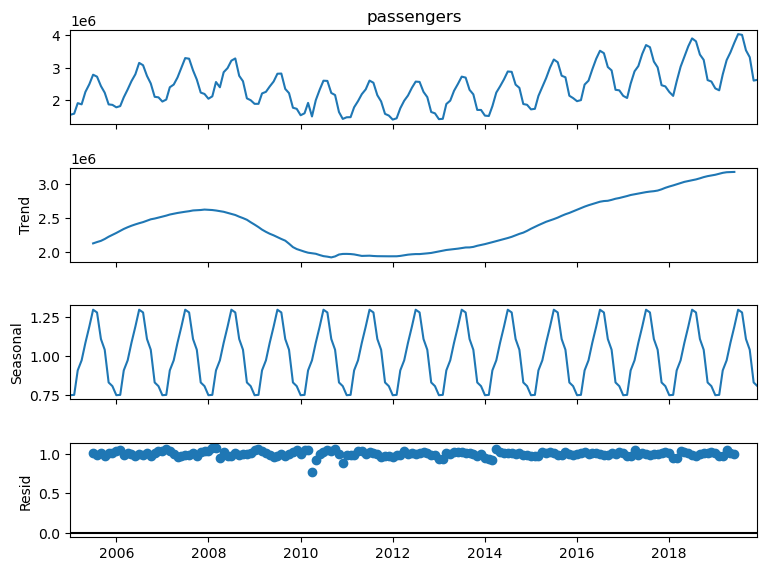

In [41]:
# model set to multiplicative when the trend is increasing over time
# period set to 12 to indicate monthly data
decompose = seasonal_decompose(passengers['passengers'],model='multiplicative',period=12)
fig = decompose.plot()
fig.set_figheight(6)
fig.set_figwidth(8)
plt.show()

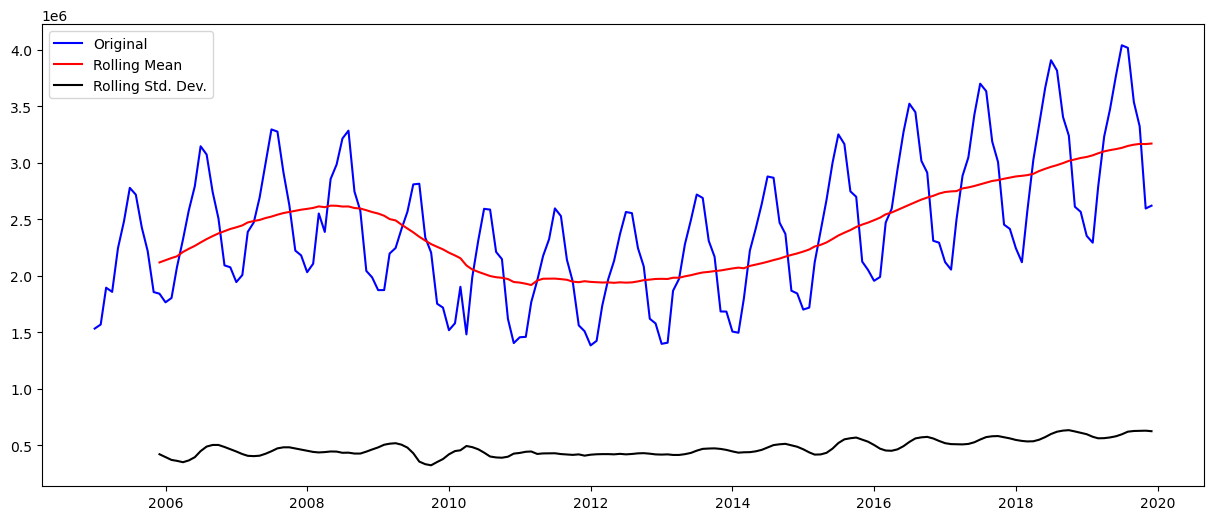

In [42]:
# Rolling Mean & Rolling Standard Deviation

#window size 12 denotes 12 months
#giving rolling mean at yearly level
rolmean = passengers['passengers'].rolling(window = 12).mean()
rolstd = passengers['passengers'].rolling(window = 12).std()

plt.figure(figsize = (15,6))
orig = plt.plot(passengers['passengers'], color = 'blue', label ='Original')
mean  = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolstd, color = 'black', label = 'Rolling Std. Dev.')
plt.legend(loc = 'best')
plt.show()

One way to test whether a time series is stationary is to perform an augmented Dickey-Fuller test, which uses the following null and alternative hypotheses:

H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

HA: The time series is stationary.

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [43]:
adf_test = ADFTest(alpha=0.5)
adf_test.should_diff(passengers['passengers'])

(0.0788164937324536, False)

From the above, we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

If the data is not stationary, we can do one thing: either make the data stationary or use the SARIMAX model.

## 2.4 splitting the data

In [44]:
passengers.head()

,passengers
date,
2005-01-01,1533700.0
2005-02-01,1569600.0
2005-03-01,1895500.0
2005-04-01,1858600.0
2005-05-01,2245500.0


In [45]:
#splitting the data 80% train, 20% test
train_data = passengers['passengers'][:int(len(passengers)*.8)]
test_data = passengers['passengers'][int(len(passengers)*0.8):]

In [46]:
train_data

date
2005-01-01    1533700.0
2005-02-01    1569600.0
2005-03-01    1895500.0
2005-04-01    1858600.0
2005-05-01    2245500.0
                ...    
2016-08-01    3448500.0
2016-09-01    3017700.0
2016-10-01    2913700.0
2016-11-01    2310700.0
2016-12-01    2293700.0
Name: passengers, Length: 144, dtype: float64

## 2.5 Using Auto ARIMA to tune hyperparameters and find optimal model

ref for auto arima: https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

In [47]:
#tuning parameters using auto-arima
arima_model = pm.auto_arima(train_data, 
                            start_p=0, d=1, start_q=0,#min p,d & q
                            max_p=5,max_d=5, max_q=5, #max p,d & q
                            start_P=0, start_Q=0,   
                            max_P=5,max_Q=5,
                            D=1,max_D=5,
                            m=12, #monthly
                            seasonal=True,
                            error_action='warn', trace=True, 
                            suppress_warnings=True, 
                            stepwise=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3448.274, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3430.793, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3428.016, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3440.814, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3427.267, Time=0.17 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3430.180, Time=0.06 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=3430.290, Time=0.30 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3430.096, Time=0.41 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3428.297, Time=0.22 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3428.965, Time=0.15 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=3431.824, Time=0.58 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3434.404, Time=0.15 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3429.192, Time=0.27 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=3429.109, Time=0.23 sec
 ARIMA(1,1,0)(1,1,1

## 2.6 Running ARIMA 

In [48]:
#fitting the training data to the model
arima_model.fit(train_data)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [49]:
#making predictions on the test data using the trained model
prediction_test = pd.DataFrame(arima_model.predict(n_periods = len(test_data)),index=test_data.index)

In [51]:
#updating prediction column to be passengers
prediction_test.columns = ['passengers']

In [52]:
prediction_test.head()

,passengers
date,
2017-01-01,2.183566e+06
2017-02-01,2.212263e+06
2017-03-01,2.661615e+06
2017-04-01,2.809242e+06
2017-05-01,3.132893e+06


## 2.7 plotting training and testing data

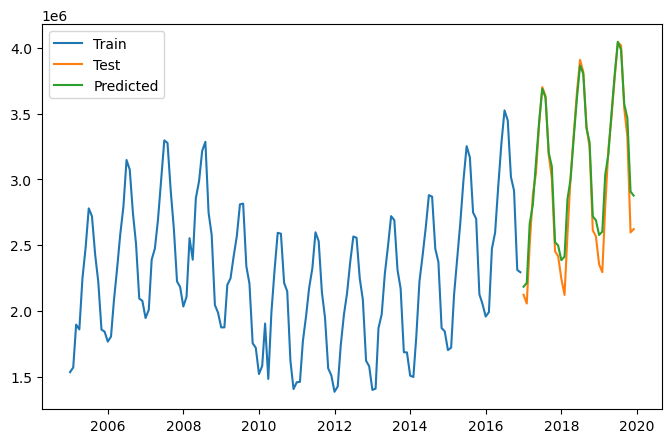

In [54]:
#plotting the predicted values against the test data and train data
plt.figure(figsize=(8,5))
plt.plot(train_data,label='Train')
plt.plot(test_data, label='Test')
plt.plot(prediction_test,label='Predicted')
plt.legend()
plt.show()

In [55]:
test = test_data.values
pred_test = prediction_test['passengers'].values

## 2.8 Evaluating Score

In [56]:
#evaluating the model accuracy on the test data
arima_r2_score = r2_score(test,pred_test)
arima_r2_score

0.9443761676007869

In [57]:
arima_r2_score = r2_score(test,pred_test)
arima_rmse = rmse(test,pred_test)
arima_mae = np.mean(np.abs((test - pred_test) / test)) * 100

In [58]:
print(f'1) the r^2 score for the test set is: {arima_r2_score}')
print(f'3) the root mean squared error for the test set is: {arima_rmse}')
print(f'4) the mean absolute error percentage for the test set is: {arima_mae}')

1) the r^2 score for the test set is: 0.9443761676007869
3) the root mean squared error for the test set is: 138653.9593973846
4) the mean absolute error percentage for the test set is: 3.9105350715726392


# Section 3 - comparing ARIMA to regression models:

In [59]:
comparison_metrics = comparison_metrics.drop(columns='r_squared_train')

In [60]:
arima_score=pd.DataFrame({'models':['ARIMA'],'r_squared_test':[arima_r2_score],'rmse_test':[arima_rmse],'mae_test':[arima_mae]})
arima_score

,models,r_squared_test,rmse_test,mae_test
0,ARIMA,0.944376,138653.959397,3.910535


In [61]:
comparison_metrics = pd.concat([comparison_metrics,arima_score])

In [62]:
comparison_metrics

,models,r_squared_test,rmse_test,mae_test
0,multivariate_LR,0.910407,4.512212e+05,4.238817
1,multivariate_LR_PCA,0.910951,4.498494e+05,4.103806
2,multivariate_LR_ridge,0.562160,9.974914e+05,8.702579
3,multivariate_LR_lasso,0.910927,4.499095e+05,4.104309
4,Random_Forrest_Regression,0.141432,1.396816e+06,11.859056
0,ARIMA,0.944376,1.386540e+05,3.910535


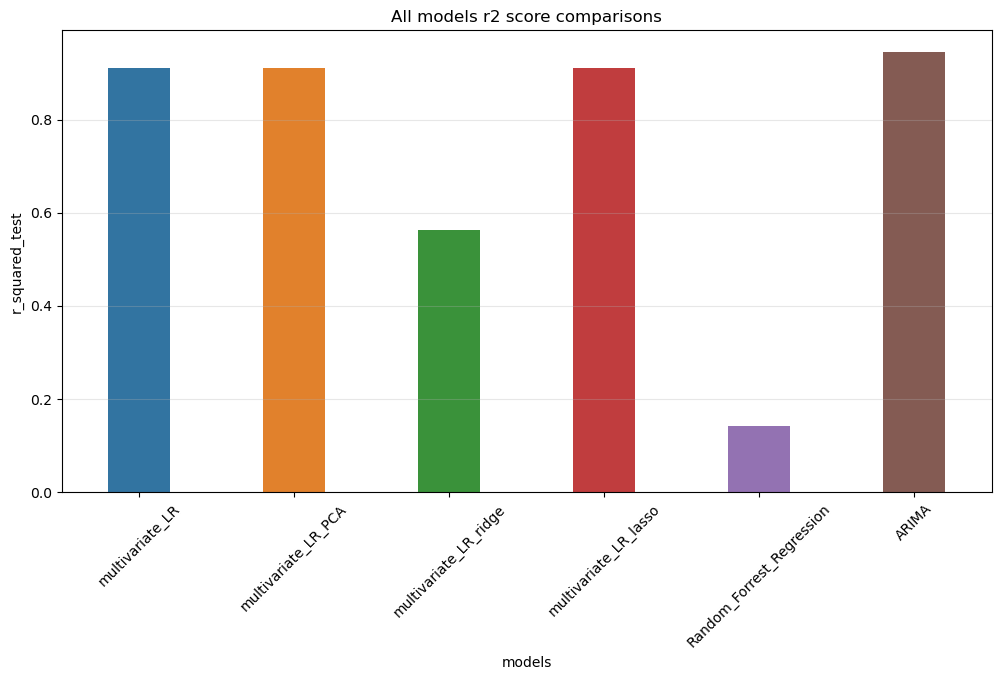

In [63]:
#plotting the accuracies using the r^2 score of each of the models used
plt.figure(figsize=(12,6))
sns.barplot(x='models',y='r_squared_test',data=comparison_metrics,width=.4)
plt.grid(axis='y',alpha=.3)
plt.title('All models r2 score comparisons')
plt.xticks(rotation=45)
plt.show()

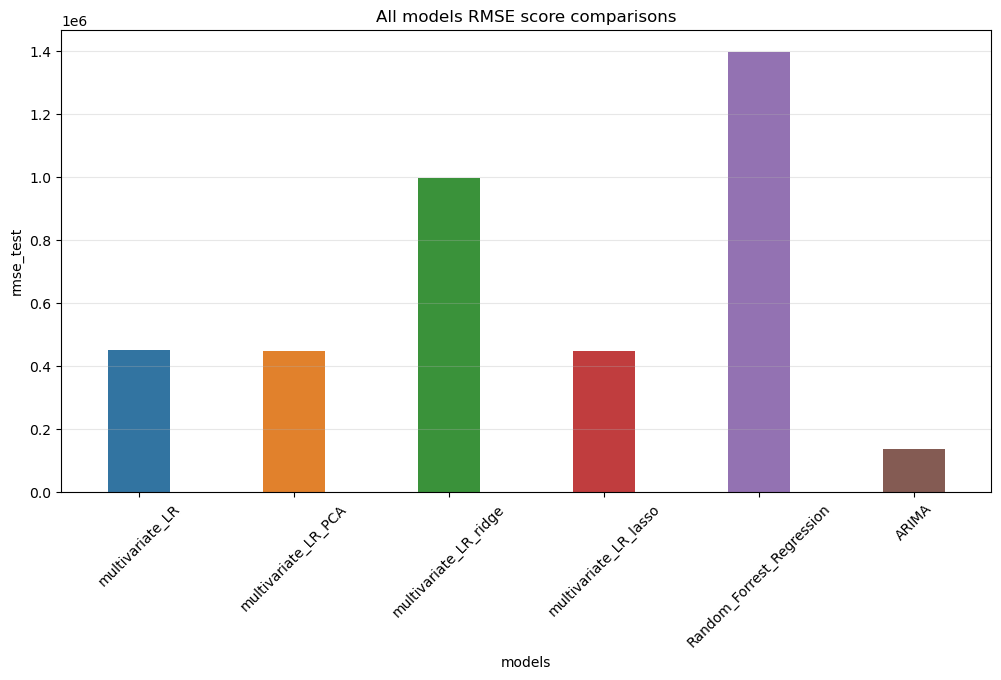

In [64]:
#plotting the accuracies using the r^2 score of each of the models used
plt.figure(figsize=(12,6))
sns.barplot(x='models',y='rmse_test',data=comparison_metrics,width=.4)
plt.grid(axis='y',alpha=.3)
plt.title('All models RMSE score comparisons')
plt.xticks(rotation=45)
plt.show()

# Section 4 - forecasting with ARIMA model

In [65]:
### forecasting using the trained model to 2030
## setting n_periods to 157 indicates the number of months I want to predict
forecast_numbers = arima_model.predict(n_periods=133)
forecast_numbers = forecast_numbers.reset_index()
forecast_numbers.columns = ['date','passengers']

In [66]:
#getting the forecasted passenger numbers for dates after the last date in the dataset
forecast_numbers = forecast_numbers[forecast_numbers['date']>'2020-03-01']

In [67]:
## adding in offset to account for missing covid years
forecast_numbers['date'] = forecast_numbers['date'] + pd.offsets.DateOffset(years=3)

In [68]:
#getting the historical numbers (i.e up until 2023-03-01)
historical_numbers = ireland_airtraffic_agg[['date','passengers']]

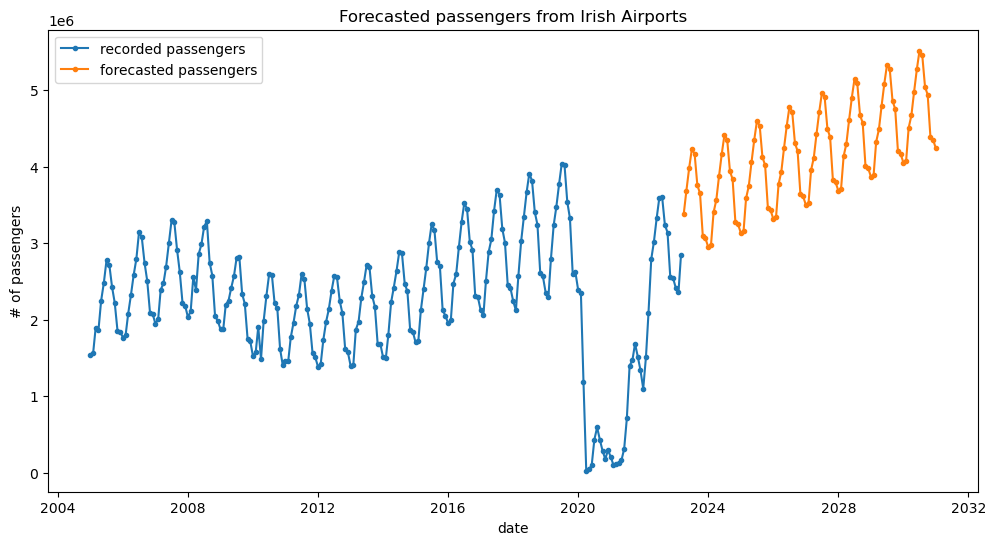

In [69]:
#plotting the recorded passengers and forecasted passengers on the same plot
plt.figure(figsize=(12,6))
plt.plot(historical_numbers['date'],historical_numbers['passengers'],'.-',label='recorded passengers')
plt.plot(forecast_numbers['date'],forecast_numbers['passengers'],'.-',label='forecasted passengers')
plt.xlabel('date')
plt.ylabel('# of passengers')
plt.title('Forecasted passengers from Irish Airports')
#plt.grid(True,alpha=0.3)
plt.legend();

In [70]:
forecast_numbers

,date,passengers
39,2023-04-01,3.380858e+06
40,2023-05-01,3.687901e+06
41,2023-06-01,3.983132e+06
42,2023-07-01,4.228285e+06
43,2023-08-01,4.168721e+06
...,...,...
128,2030-09-01,5.043765e+06
129,2030-10-01,4.938269e+06
130,2030-11-01,4.381710e+06
131,2030-12-01,4.350269e+06


In [71]:
forecast_numbers['year']=pd.DatetimeIndex(forecast_numbers['date']).year

In [72]:
yearly_forecast = forecast_numbers.groupby('year')['passengers'].sum().reset_index()

In [73]:
yearly_forecast

,year,passengers
0,2023,3.301003e+07
1,2024,4.399059e+07
2,2025,4.619943e+07
3,2026,4.840738e+07
4,2027,5.061495e+07
5,2028,5.282238e+07
6,2029,5.502974e+07
7,2030,5.723708e+07
8,2031,4.237204e+06


In [74]:
#renaming column to enable it to be merged with the forecasted figures for each airport later
forecast_numbers = forecast_numbers.rename(columns={'passengers':'All'})

In [75]:
forecast_numbers.head()

,date,All,year
39,2023-04-01,3.380858e+06,2023
40,2023-05-01,3.687901e+06,2023
41,2023-06-01,3.983132e+06,2023
42,2023-07-01,4.228285e+06,2023
43,2023-08-01,4.168721e+06,2023


## 4.1 forecasting for each airport in Ireland

In this section I will iterate through each of the 5 airports in Ireland using the same method of ARIMA time series forecasting explored above to get some forecasts for each airport in Ireland.<br>
The main reason I will do this is to populate a forecast table for the dashboard developed as part of this project:

In [76]:
#loading in the data, this time I will load in the unaggregated data
ireland_airtraffic = pd.read_csv('ireland_airtraffic.csv')

#summing passengers by year, month, airport as I want to ignore country, route, type columns
airtraffic_by_airport = ireland_airtraffic.groupby(['year','month','airport'])['passengers'].sum().reset_index()

In [77]:
airtraffic_by_airport

,year,month,airport,passengers
0,2005,1,Cork,152900.0
1,2005,1,Dublin,1162600.0
2,2005,1,Kerry,23300.0
3,2005,1,Knock,26900.0
4,2005,1,Shannon,168100.0
...,...,...,...,...
1090,2023,3,Cork,180800.0
1091,2023,3,Dublin,2459700.0
1092,2023,3,Kerry,26100.0
1093,2023,3,Knock,51200.0


### 4.1.1 Creating function to run ARIMA on airport passed as argument

- Defining a function **"forecast_by_airport"** to avoid repeating code for producing time series forecasting using the auto ARIMA method for each airport. Using this function I should be able to pass the name of the airport as a string and it will return back a dataframe of the forecasted values for the next 7 years (to 2023).
- The contents of this function are exactly the same as described above when forecasting for all airports in Ireland, only this time it will consisted of a variable "airport" which is what is passed into the function.

In [78]:
def forecast_by_airport(airport,agg_df):
    #filtering by selected airport from airport_df
    airport_df = airtraffic_by_airport[airtraffic_by_airport['airport']==airport]
    #dropping airport column as it is not needed now
    airport_df = airport_df.drop(columns = 'airport')
    #updating date to datetime format for modelling purposes
    airport_df['day'] = 1
    airport_df['date'] = pd.to_datetime(airport_df[['year','month','day']])
    
    #removing covid years
    airport_df_model = airport_df[(airport_df['year']<2020)]
    #selecting only date and passenger columns
    airport_df_model = airport_df_model[['date','passengers']]
    #setting date as index
    airport_df_model = airport_df_model.set_index('date')
    
    #splitting the data 80% train, 20% test
    train_data = airport_df_model['passengers'][:int(len(airport_df_model)*0.8)]
    test_data = airport_df_model['passengers'][int(len(airport_df_model)*0.8):]
    
    #tuning parameters using auto-arima
    arima_model = pm.auto_arima(train_data, 
                                start_p=0, d=1, start_q=0,#min p,d & q
                                max_p=5,max_d=5, max_q=5, #max p,d & q
                                start_P=0, start_Q=0, 
                                max_P=5,max_Q=5,
                                D=1,max_D=5,
                                m=12, #monthly
                                seasonal=True,
                                error_action='warn',
                                suppress_warnings=True, 
                                stepwise=True,n_fits=50);
    
    #fitting the training data to the model
    arima_model.fit(train_data)
    
    prediction = pd.DataFrame(arima_model.predict(n_periods = len(test_data)),index=test_data.index)
    prediction.columns = ['passengers']
    
    ### forecasting using the trained model to 2030
    forecast_numbers = arima_model.predict(n_periods=133)
    forecast_numbers = forecast_numbers.reset_index()
    forecast_numbers.columns = ['date',airport]
    
    forecast_numbers = forecast_numbers[forecast_numbers['date']>'2020-03-01']
    ## adding in offset to account for missing covid years
    forecast_numbers['date'] = forecast_numbers['date'] + pd.offsets.DateOffset(years=3)

    return forecast_numbers


In [79]:
#running the forecast model for each airport in Ireland
dublin_forecast = forecast_by_airport('Dublin',airtraffic_by_airport) 
cork_forecast = forecast_by_airport('Cork',airtraffic_by_airport)
kerry_forecast = forecast_by_airport('Kerry',airtraffic_by_airport)
knock_forecast = forecast_by_airport('Knock',airtraffic_by_airport)
shannon_forecast = forecast_by_airport('Shannon',airtraffic_by_airport)

In [80]:
#merging all datasets together
merged_forecasts = dublin_forecast.merge(cork_forecast, on='date',how='left')
merged_forecasts = merged_forecasts.merge(kerry_forecast, on='date',how='left')
merged_forecasts = merged_forecasts.merge(knock_forecast, on='date',how='left')
merged_forecasts = merged_forecasts.merge(shannon_forecast, on='date',how='left')
merged_forecasts = merged_forecasts.merge(forecast_numbers,on='date',how='left')

In [81]:
merged_forecasts_yearly = merged_forecasts.groupby('year')[['Dublin','Cork','Kerry','Knock','Shannon','All']].sum().reset_index()
merged_forecasts_yearly

,year,Dublin,Cork,Kerry,Knock,Shannon,All
0,2023,2.961695e+07,2.052649e+06,303448.246321,7.357455e+05,1.433478e+06,3.301003e+07
1,2024,4.007958e+07,2.637204e+06,381252.668949,9.372502e+05,1.753050e+06,4.399059e+07
2,2025,4.256241e+07,2.720130e+06,390222.771087,9.750575e+05,1.768997e+06,4.619943e+07
3,2026,4.504525e+07,2.803056e+06,399192.873225,1.012865e+06,1.784945e+06,4.840738e+07
4,2027,4.752808e+07,2.885982e+06,408162.975362,1.050672e+06,1.800893e+06,5.061495e+07
5,2028,5.001091e+07,2.968907e+06,417133.077500,1.088479e+06,1.816840e+06,5.282238e+07
6,2029,5.249374e+07,3.051833e+06,426103.179638,1.126287e+06,1.832788e+06,5.502974e+07
7,2030,5.497657e+07,3.134759e+06,435073.281776,1.164094e+06,1.848736e+06,5.723708e+07
8,2031,4.173654e+06,2.097340e+05,26716.710390,7.385592e+04,1.036910e+05,4.237204e+06


In [82]:
#saving to csv to be used for dashboard later
merged_forecasts.to_csv('passenger_forecasts.csv',index=False)

In [136]:
#saving to csv to be used for dashboard later
merged_forecasts_yearly.to_csv('passenger_forecasts_yearly.csv',index=False)

# Section 5: Sentiment Analysis

### The aim of this section is to perform sentimental analysis on each of Irelands main airports.

## Steps for sentiment analysis

- Text Preprocessing: The text data is cleaned by removing irrelevant information, such as special characters, punctuation, and stopwords.
- Tokenization: The text is divided into individual words or tokens to facilitate analysis.
- Feature Extraction: Relevant features are extracted from the text, such as words, n-grams, or even parts of speech.
- Sentiment Classification: Machine learning algorithms or pre-trained models are used to classify the sentiment of each text instance. This can be achieved through supervised learning, where models are trained on labeled data, or through pre-trained models that have learned sentiment patterns from large datasets.
- Post-processing: The sentiment analysis results may undergo additional processing, such as aggregating sentiment scores or applying threshold rules to classify sentiments as positive, negative, or neutral.
- Evaluation: The performance of the sentiment analysis model is assessed using evaluation metrics, such as accuracy, precision, recall, or F1 score.

In [85]:
#Read config.ini file which contains API keys, passwords, usernames to access the APIs
config_object = ConfigParser()
config_object.read("config.ini")

#Get the info
redditInfo = config_object["REDDITAPI"]
googleinfo = config_object["GOOGLEAPI"]

## 5.1 Getting text from different sources

### 5.1.1 using google places API to get google reviews for each airport

- The below function makes use of the googlemaps python library which enables a user to send a request to the google places API to fetch any reviews relating to business/place/tourist attraction etc that can be search via google.
- To use this I must create a API key which I have stored in a config file to keep it protected. 
- By passing a placename to the api (i.e Dublin Airport) I can search for reviews related to this place by drilling down -> results-> reviews -> text

In [86]:

def google_API(airport,key):
    #accessing API using api key set up using google account
    gmaps = googlemaps.Client(key=key)
    place_name = airport
    #searching for specified airport on googlemaps places api
    places_result = gmaps.places(place_name)
    #getting the place_id to search for results relating to the specified place
    place_id = places_result['results'][0]['place_id']
    #getting results
    place = gmaps.place(place_id = place_id)
    
    reviews = []
    #looping through the reviews
    for i in range (len(place['result']['reviews'])):
        text = place['result']['reviews'][i]['text']
        #rating = place['result']['reviews'][i]['rating']
        reviews.append(text)
    
    #creating dataframe from reviews list
    df = pd.DataFrame({airport:reviews})
    return df    

In [87]:
#querying google places api for reviews on each airport in Ireland
dub_google = google_API('Dublin Airport',googleinfo['key'])
cork_google = google_API('Cork Airport',googleinfo['key'])
knock_google = google_API('Knock Airport',googleinfo['key'])
kerry_google = google_API('Kerry Airport',googleinfo['key'])
shannon_google = google_API('Shannon Airport',googleinfo['key'])

**Note:** With the google places API, unless you have a business or premium account, you cannot pull back more than 5 reviews for each unique place (i.e each airport in this case).

### 5.1.2 Scraping airlinequality.com website for reviews:

- To get some more reviews on each airport, I then opted for scraping reviews directly from airlinequality.com which is a review website operated by skytrax as an independent customer forum for airline, airport and associated air travel reviews.

- To do this I created a function again, which will enable the scraping to be performed on any specified airport.

- This function uses the Requests library in combination with the beautifulSoup library to load and parse the raw html directly from the specified url. Using this html I am able to parse through it to pull out the text content and subsequently find each review.

- Since some of the reviews are spread across multiple pages, I used a "while" loop to check that the text_content wasnt null, in which point, the code would break and return all the reviews as a dataframe.


In [88]:
#defining function to scrape the skytrax (aka airlinequality.com) for reviews
def scrape_skytrax(airport,url_value):
    text=[]
    page_no = 1
    
    #while loop to iterate through each page of reviews on the url
    while True:
        #specifuying the url based an the airport passed to the function
        url= f'https://www.airlinequality.com/airport-reviews/{url_value}/page/{page_no}/'
        #using requesets to get the raw html
        response = requests.get(url)
        content = response.content
        #parsing the html using BeautifulSoup
        soup = BeautifulSoup(content, 'html.parser')
        #pulling out the text from the soup 
        text_content = soup.find_all("div",{"class":"text_content"})
        
        #unless text_content is null, keep searching for more reviews
        if len(text_content)!=0:
            for i in text_content:
                review = i.text
                #removing anything before | will allow me to ignore non-review text (i.e username, review date etc) 
                if "|" in review:
                    split_string = review.split('|')
                    review = split_string[1].strip()
                text.append(review)
            page_no+=1
        elif len(text_content)==0:
            break

    df = pd.DataFrame({airport:text})
    return df

In [89]:
#running web scraping for each airport in ireland
dub_skytrax = scrape_skytrax('Dublin Airport','dublin-airport')
cork_skytrax = scrape_skytrax('Cork Airport','cork-airport')
knock_skytrax = scrape_skytrax('Knock Airport','ireland-west-knock-airport')
kerry_skytrax = scrape_skytrax('Kerry Airport','kerry-airport')
shannon_skytrax = scrape_skytrax('Shannon Airport','shannon-airport')

### 5.1.3 Looking at Reddit API

- Finally to get more text relating to each Airport in Ireland, I also found the reddit API useful for extracting sentiment relating to each airport in Ireland. 
- By searching key words i.e Dublin airport in the "Ireland" sub-reddit, I was able to get some general comments on each of the airports in ireland from reddit users.
- This was done using the praw library ref: https://praw.readthedocs.io/en/stable/
- Similarly to the googleAPI, i also stored all api details in the config file to keep them hidden

In [90]:
#creating reddit instance by sending api key, username and password to reddit api for authentication using praw
reddit = praw.Reddit(
    client_id = redditInfo['personal_use_script'],
    client_secret = redditInfo['secret'],
    user_agent = 'my_app/v0.0.1',
    username = redditInfo['username'],
    password = redditInfo['password']
)

In [91]:
#creating reddit_API function to be used for any specified query, within the Ireland subreddit
def reddit_API(instance,query):
    #using reddit.subreddit to query a specified subreddit for a specified query (i.e Dublin Airport)
    top_posts = reddit.subreddit('Ireland').search(query,sort = 'relevance',limit=None)
    reddit_dict = {query: []}
    #iterating through all posts on the subreddit and appending to their titles to be added into final dataframe
    for submission in top_posts:
        reddit_dict[query].append(submission.title+". "+submission.selftext)
    df = pd.DataFrame(reddit_dict)
    return df

In [92]:
#running function for all airports
dub_reddit = reddit_API(reddit,'Dublin Airport')
cork_reddit = reddit_API(reddit,'Cork Airport')
knock_reddit = reddit_API(reddit,'Knock Airport')
kerry_reddit = reddit_API(reddit,'Kerry Airport')
shannon_reddit = reddit_API(reddit,'Shannon Airport')

### 5.1.4 creating data frames with all text merged together for each airport in Ireland

In [93]:
#mering all text from above three sources together for sentiment analysis
dublin_text = pd.concat([dub_google,dub_skytrax,dub_reddit]).reset_index().drop(columns=('index'))
cork_text = pd.concat([cork_google,cork_skytrax,cork_reddit]).reset_index().drop(columns=('index'))
knock_text = pd.concat([knock_google,knock_skytrax,knock_reddit]).reset_index().drop(columns=('index'))
kerry_text = pd.concat([kerry_google,kerry_skytrax,kerry_reddit]).reset_index().drop(columns=('index'))
shannon_text = pd.concat([shannon_google,shannon_skytrax,shannon_reddit]).reset_index().drop(columns=('index'))

In [94]:
#saving all concatinated dataframes to csv
#dublin_text.to_csv('dublin_text.csv')
#cork_text.to_csv('cork_text.csv')
#knock_text.to_csv('knock_text.csv')
#kerry_text.to_csv('kerry_text.csv')
#shannon_text.to_csv('shannon_text.csv')

## 5.2 Performing sentiment analysis on the text

### 5.2.1 Text Preprocessing: 

**1) Text Preprocessing:**

- Removing punctuations like . , ! $( ) * % @
- Removing URLs
- Removing Stop words
- Lower casing
- Tokenization
- Stemming
- Lemmatization

In [95]:
#creating stop_words variable imported from the nltk.corpus library
stop_words = set(stopwords.words("english"))

#initializing stemmer as the porter stemmer algorithm 
# this is done to reduce words to their base or root forms for better analysis and understanding
stemmer = PorterStemmer()

In [96]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [97]:
#creating function for ease of processing all text in teach of the 5 dataframes created for each airport

def pre_processing_func(df):
    #removing special characters
    df['model_text'] = df[df.columns[0]].apply(lambda x: ''.join(x for x in x if x not in string.punctuation))

    #putting every word in lower case
    df['model_text'] = df['model_text'].apply(lambda x: x.lower())

    #removing the stop words
    df['model_text'] = df['model_text'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    
    #tokenization
    df['model_text'] = df['model_text'].apply(lambda x: word_tokenize(x))
    
    #stemming
    df['model_text']= df['model_text'].apply(lambda x:[stemmer.stem(word) for word in x])
    
    #joining back to form one string
    df['model_text']=df['model_text'].apply(lambda x: ' '.join(x))

    return df

In [98]:
#running the text processing function on the text within each dataframe for each airport
dublin_text = pre_processing_func(dublin_text)
cork_test = pre_processing_func(cork_text)
kerry_text = pre_processing_func(kerry_text)
knock_text = pre_processing_func(knock_text)
shannon_text = pre_processing_func(shannon_text)

## Evaluating different methods at identifying the sentiment of the text:
- Text Blob
- VADER
- Bag of Words

### 5.2.2 Using Text Blob
ref: https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524

textblob lib: https://pypi.org/project/textblob/0.9.0/

In [99]:
## defining functions for textblob

#first function is designed to identify is the sentiment is negative,postive or neutral based on a defined threshold
def get_sentiment(polarity, pos_threshold=0.05, neg_threshold=-0.05):    
    sentiment = "neutral"

    if(polarity >= pos_threshold):
        sentiment = "positive"

    elif(polarity <= neg_threshold):
        sentiment = "negative"

    return sentiment


#second function is designed to run TextBlob sentiment function from the textblob library on each piece of text
def text_blob_func(df):
    #using a lambda function to apply textBlob to each piece of text
    df['TextBlob_polarity']=df['model_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    #applying get_sentiment to determine polarity of the text
    df['TextBlob_sentiment'] = df['TextBlob_polarity'].apply(get_sentiment)
    #sorting by sentiment
    df = df.sort_values('TextBlob_sentiment',ascending=False)
    
    #getting the proportion of the text that is positive,negative and neutral
    positive_prop = (df[df['TextBlob_sentiment']=='positive'].TextBlob_sentiment.count())/len(df)
    negative_prop = (df[df['TextBlob_sentiment']=='negative'].TextBlob_sentiment.count())/len(df)
    neutral_prop = (df[df['TextBlob_sentiment']=='neutral'].TextBlob_sentiment.count())/len(df)
    
    return df, positive_prop, negative_prop, neutral_prop

In [100]:
#running the textblob function on each airport
dublin_sentiment = text_blob_func(dublin_text)
cork_sentiment = text_blob_func(cork_text)
kerry_sentiment = text_blob_func(kerry_text)
knock_sentiment = text_blob_func(knock_text)
shannon_sentiment = text_blob_func(shannon_text)

In [101]:
#to enable plotting the polarities for each airport I have created a list of each of the polarity scores 
TEXT_BLOB_List = [dublin_sentiment,cork_sentiment,kerry_sentiment,knock_sentiment,shannon_sentiment]
cols = ['Dublin','Cork','Kerry','Knock','Shannon']

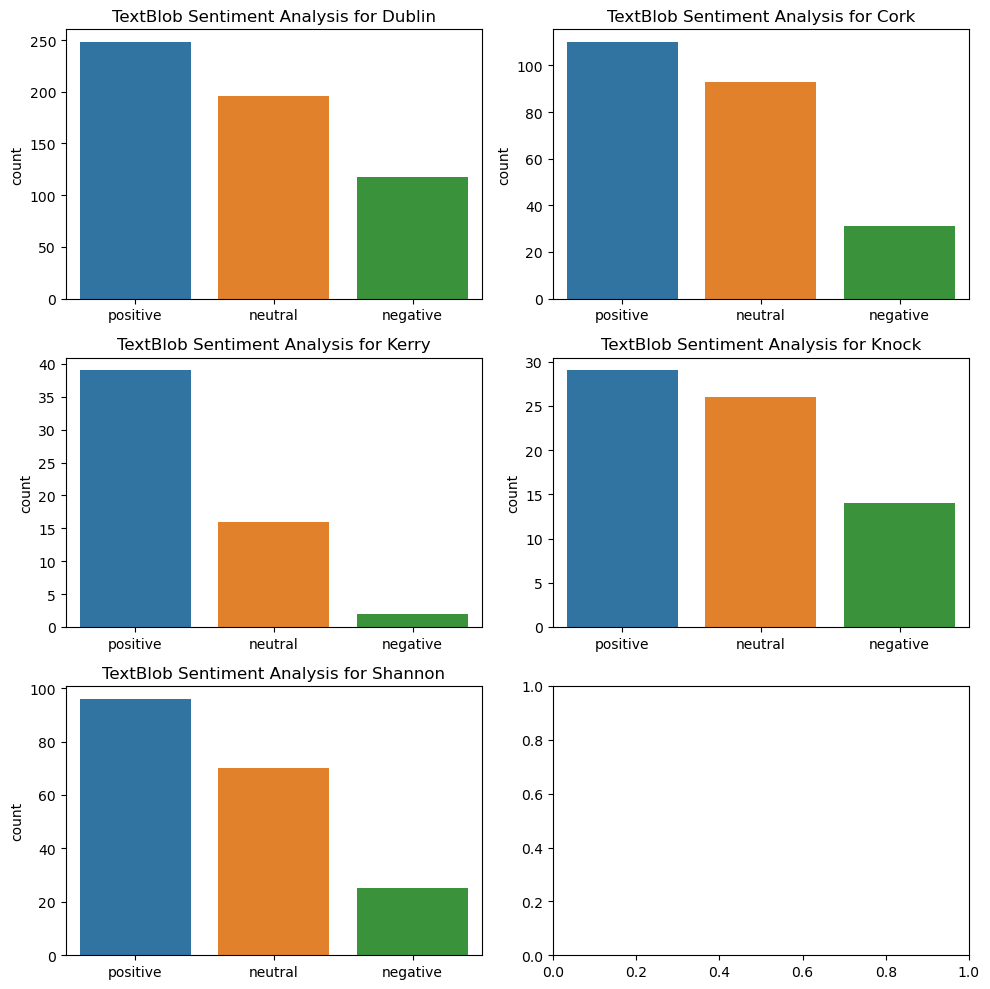

In [102]:
#plotting polarity for each airport in Ireland using subplots

fig,axes = plt.subplots(3,2,figsize=(10,10))
axes = axes.ravel()

for col,ax in zip(cols,axes):
    #using count plot to count the amount of times text is positive,negative or neutral for each airport
    sns.countplot(x='TextBlob_sentiment', data=TEXT_BLOB_List[cols.index(col)][0],ax=ax)
    ax.set_title(f'TextBlob Sentiment Analysis for {col}')
    ax.set_xlabel('')

fig.tight_layout()
plt.show()

In [103]:
df = pd.DataFrame()

#getting the proportions for each airport in Ireland to enable a comparison plot to be created
for col in cols:
    pos_prop = TEXT_BLOB_List[cols.index(col)][1]
    neg_prop = TEXT_BLOB_List[cols.index(col)][2]
    neut_prop = TEXT_BLOB_List[cols.index(col)][3]
    
    #creating a dataframe out of the airport and each polarity proportion value
    data = pd.DataFrame({'airport':[col],'positive prop':[pos_prop],'neutral prop':[neut_prop],'negative prop':[neg_prop]})
    df = pd.concat([df,data])

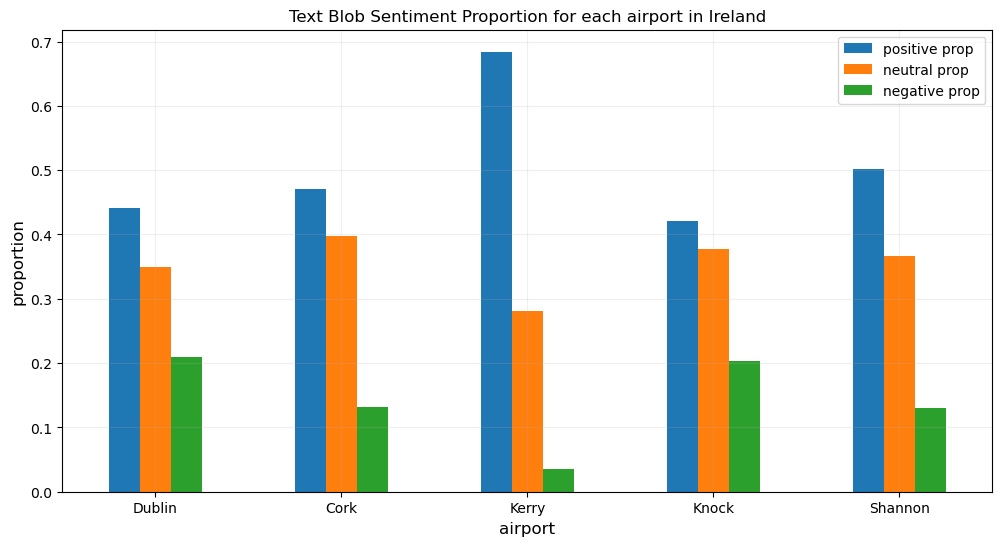

In [104]:
#plotting the sentiment proportion for each airport in Ireland on a grouped bar chart
plt.figure(figsize=(12,6))
df.plot(x='airport',kind='bar', stacked=False, ax = plt.gca())
plt.title('Text Blob Sentiment Proportion for each airport in Ireland')
plt.ylabel('proportion',size=12)
plt.xlabel('airport',size=12)
plt.xticks(rotation=0)
plt.grid(True,alpha=.2)
plt.show()

### 5.2.3 Using VADER

ref: https://pypi.org/project/vaderSentiment/

In [105]:
# Create a SentimentIntensityAnalyzer object
sent_analyzer = SentimentIntensityAnalyzer()

In [106]:
def vader_func(df):
    df['VADER_compound']=df['model_text'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
    df['VADER_sentiment']=df['VADER_compound'].apply(get_sentiment)
    df = df.sort_values('VADER_sentiment',ascending=False)
    
    positive_prop = (df[df['VADER_sentiment']=='positive'].VADER_sentiment.count())/len(df)
    negative_prop = (df[df['VADER_sentiment']=='negative'].VADER_sentiment.count())/len(df)
    neutral_prop = (df[df['VADER_sentiment']=='neutral'].VADER_sentiment.count())/len(df)
    
    return df, positive_prop, negative_prop, neutral_prop

In [107]:
dublin_sentiment = vader_func(dublin_text)
cork_sentiment = vader_func(cork_text)
kerry_sentiment = vader_func(kerry_text)
knock_sentiment = vader_func(knock_text)
shannon_sentiment = vader_func(shannon_text)

In [108]:
VADER_List = [dublin_sentiment,cork_sentiment,kerry_sentiment,knock_sentiment,shannon_sentiment]
cols = ['Dublin','Cork','Kerry','Knock','Shannon']

In [109]:
df = pd.DataFrame()

for col in cols:
    pos_prop = VADER_List[cols.index(col)][1]
    neg_prop = VADER_List[cols.index(col)][2]
    neut_prop = VADER_List[cols.index(col)][3]
    data = pd.DataFrame({'airport':[col],'positive prop':[pos_prop],'neutral prop':[neut_prop],'negative prop':[neg_prop]})
    df = pd.concat([df,data])

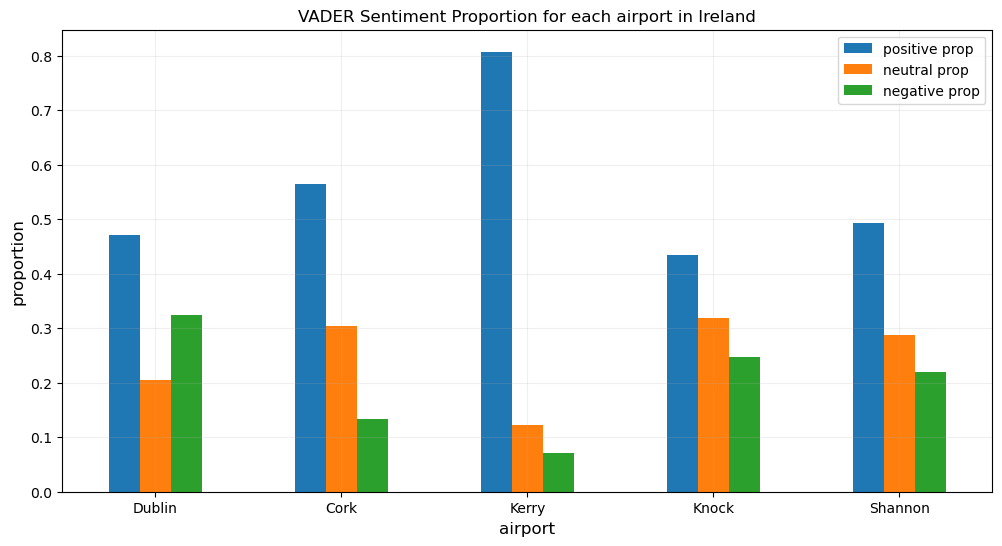

In [110]:
plt.figure(figsize=(12,6))
df.plot(x='airport',kind='bar', stacked=False, ax = plt.gca())
plt.title('VADER Sentiment Proportion for each airport in Ireland')
plt.ylabel('proportion',size=12)
plt.xlabel('airport',size=12)
plt.xticks(rotation=0)
plt.grid(True,alpha=.2)
plt.show()

### 5.2.4 Using Bag of Words (Vectorization based model) - Dublin Airport Only

In [111]:
dublin_df = dublin_sentiment[0]

In [112]:
dublin_df.head()

,Dublin Airport,model_text,TextBlob_polarity,TextBlob_sentiment,VADER_compound,VADER_sentiment
0,Great airport. Very well organized. Fast secur...,great airport well organ fast secur custom ser...,0.400000,positive,0.7351,positive
298,Arrived at Terminal 2 on an Aer Lingus flight ...,arriv termin 2 aer lingu flight uk expect pick...,0.254167,positive,0.3612,positive
262,We visit Dublin approx 4 times per year on tri...,visit dublin approx 4 time per year trip visit...,0.208333,positive,0.7940,positive
260,I fly regularly from the US to multiple cities...,fli regularli us multipl citi europ one conven...,0.500000,positive,0.7269,positive
258,I am delighted to say that I used Dublin airpo...,delight say use dublin airport twice last mont...,0.118273,positive,0.9300,positive


In [113]:
dublin_df.rename(columns={'model_text':'text','VADER_sentiment':'sentiment'}, inplace=True)
dublin_df = dublin_df.drop(columns=['Dublin Airport','TextBlob_polarity','TextBlob_sentiment','VADER_compound'])

In [114]:
dublin_df

,text,sentiment
0,great airport well organ fast secur custom ser...,positive
298,arriv termin 2 aer lingu flight uk expect pick...,positive
262,visit dublin approx 4 time per year trip visit...,positive
260,fli regularli us multipl citi europ one conven...,positive
258,delight say use dublin airport twice last mont...,positive
...,...,...
342,dublin airport roundabout block off…again,negative
344,dublin airport price breakfast someon tell bla...,negative
350,break hare fag mouth spot wait bu dublin airport,negative
60,dublin airport absolut disgrac upon arriv wife...,negative


In [115]:
#extracing the text only
text_data = []

for i in range(len(dublin_df)):
    text = dublin_df.iloc[i].text
    text_data.append(text)

In [116]:
# Collect all columns into dataframe named as sentiment_ordering
sentiment_ordering = ['negative', 'neutral', 'positive']

# store all values into column named as "y"
y = dublin_df['sentiment'].apply(lambda x: sentiment_ordering.index(x))

#### 5.2.4.1 count vectorizer method

In [117]:
# Instantiate an object cv by calling a method named as CountVectorzer()
#setting stop words as "dublin" and "airport" as these are commonly occuring words in the text
vect = CountVectorizer(max_features = 3000, stop_words=['dublin', 'airport'] )

X  = vect.fit_transform(text_data).toarray()

X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [118]:
# Instantiate an object model by calling a method MultinomialNB()
model = MultinomialNB()

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

In [120]:
# Train the model by calling a method fit()
model.fit(X_train,y_train)

MultinomialNB()

In [121]:
# Call predict() method
y_pred = model.predict(X_test)

In [122]:
report = classification_report(y_test, y_pred)

# Display the values of an object cf
print(report)

              precision    recall  f1-score   support

           0       0.63      0.47      0.54        55
           1       0.62      0.26      0.36        31
           2       0.68      0.94      0.79        83

    accuracy                           0.66       169
   macro avg       0.64      0.56      0.56       169
weighted avg       0.65      0.66      0.63       169



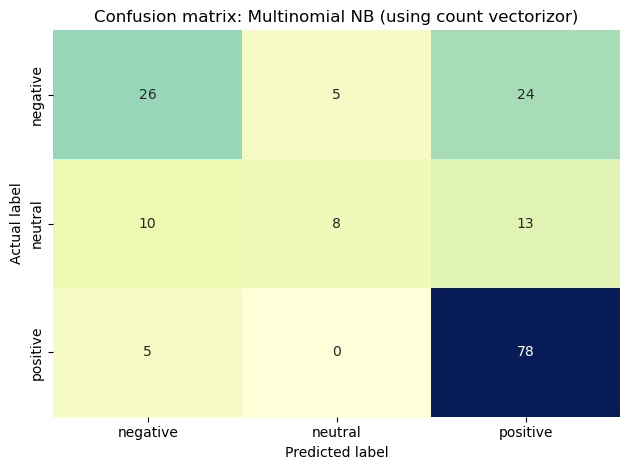

              precision    recall  f1-score   support

           0       0.63      0.47      0.54        55
           1       0.62      0.26      0.36        31
           2       0.68      0.94      0.79        83

    accuracy                           0.66       169
   macro avg       0.64      0.56      0.56       169
weighted avg       0.65      0.66      0.63       169



In [123]:
confusion_MNB = metrics.confusion_matrix(y_test, y_pred)

class_names=['negative', 'neutral', 'positive']
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(confusion_MNB), annot=True, cmap="YlGnBu" ,fmt='g',
            xticklabels=class_names,yticklabels=class_names,cbar=False)
plt.title('Confusion matrix: Multinomial NB (using count vectorizor)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show() 

print(classification_report(y_test,y_pred))

In [124]:
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Rounded upto 2 decimal places
print( "Accuracy: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)) )

Accuracy: 0.6627218934911243
Accuracy: 0.66


#### Cross Validation

In [125]:
model = MultinomialNB()
cv_results = cross_val_score(model, X, y, scoring='accuracy', cv = 20)
print('Cross-validated scores:\n ', cv_results)

Cross-validated scores:
  [0.68965517 0.65517241 0.64285714 0.75       0.71428571 0.78571429
 0.60714286 0.53571429 0.53571429 0.57142857 0.60714286 0.57142857
 0.64285714 0.75       0.42857143 0.42857143 0.46428571 0.5
 0.60714286 0.57142857]


In [126]:
print(f'Mean cross validation score of {cv_results.mean()}')

Mean cross validation score of 0.6029556650246304


- Cross_val_score is a method which runs k-fold cross validation on a dataset to test whether the model can generalise over the whole dataset.
- The function returns a list of one score per split, and the average of these scores can be calculated to provide a single metric value for the dataset.

Since the accuracy obtained by my model (0.6449) is larger than the mean from the cross validation score, I can conclude that the model generalises well over the whole data set.

#### 5.2.4.2 using TF - IDF instead of count vectorizer

In [127]:
# Create an object 'tf' by calling a method TfidfVectorizer()
tfidf = TfidfVectorizer(max_features = 3000, stop_words = ['dublin', 'airport'])

# Train the dataset by calling a method fit_tranform() 
X_tfidf = tfidf.fit_transform(text_data).toarray()

In [128]:
X_tfidf.shape

(562, 3000)

In [129]:
model_tdidf = MultinomialNB()

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.3,random_state=42)

In [131]:
model_tdidf.fit(X_train, y_train)

MultinomialNB()

In [132]:
y_pred = model_tdidf.predict(X_test)

In [133]:
reportTFIDF = classification_report(y_test, y_pred)
print(reportTFIDF)

              precision    recall  f1-score   support

           0       1.00      0.13      0.23        55
           1       0.00      0.00      0.00        31
           2       0.51      1.00      0.68        83

    accuracy                           0.53       169
   macro avg       0.50      0.38      0.30       169
weighted avg       0.58      0.53      0.41       169



#### Cross Validation

In [134]:
model = MultinomialNB()
cv_results = cross_val_score(model, X_tfidf, y, scoring='accuracy', cv = 20)
print('Cross-validated scores:\n ', cv_results)

Cross-validated scores:
  [0.5862069  0.48275862 0.53571429 0.60714286 0.57142857 0.5
 0.46428571 0.46428571 0.5        0.46428571 0.46428571 0.5
 0.46428571 0.5        0.5        0.5        0.42857143 0.46428571
 0.53571429 0.5       ]


In [135]:
print(f'Mean cross validation score of {cv_results.mean()}')

Mean cross validation score of 0.5016625615763547


- Cross_val_score is a method which runs k-fold cross validation on a dataset to test whether the model can generalise over the whole dataset.
- The function returns a list of one score per split, and the average of these scores can be calculated to provide a single metric value for the dataset.

Since the accuracy obtained by my model (0.51) is larger than the mean from the cross validation score, I can conclude that the model generalises well over the whole data set.